In [1]:
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.


,Sector,Beta (per 100bps Δ10Y),t-stat,p-value,R-squared,N
4,Utilities (XLU),-0.011763,-1.033426,3.014044e-01,0.002593,1490
3,Consumer Staples (XLP),0.001523,0.199738,8.416854e-01,0.000079,1490
0,Technology (XLK),0.017954,1.482720,1.381489e-01,0.003861,1490
1,Financials (XLF),0.047818,4.104885,4.045156e-05,0.033019,1490
2,Energy (XLE),0.074471,4.900711,9.549056e-07,0.042144,1490


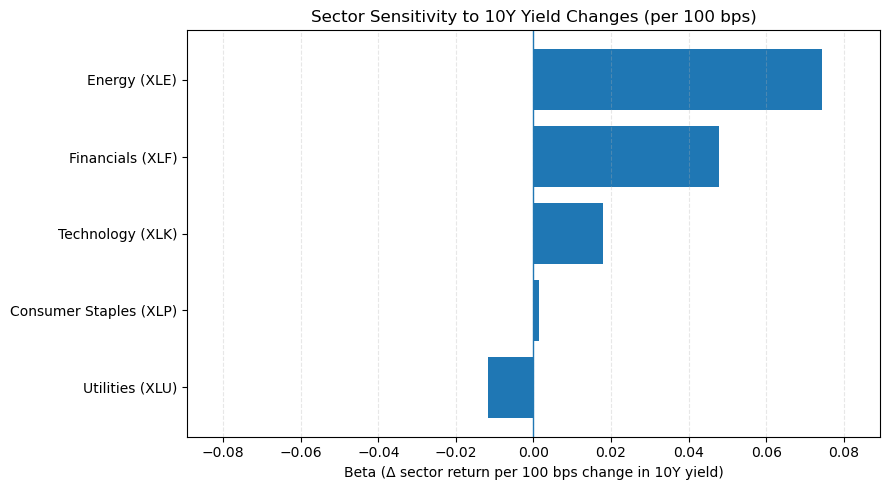

Saved figure → results/figures/sector_sensitivity.png
Saved table  → results/tables/sector_rate_sensitivity.csv


In [5]:
# ===============================
# Sector Sensitivity (per 100 bps Δ10Y Yield)
# ===============================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf
from pandas_datareader import data as web

# ---------- Parameters ----------
start = "2020-01-01"
end = "2025-12-31"

sectors = {
    "Technology (XLK)": "XLK",
    "Financials (XLF)": "XLF",
    "Energy (XLE)": "XLE",
    "Consumer Staples (XLP)": "XLP",
    "Utilities (XLU)": "XLU"
}

os.makedirs("results/figures", exist_ok=True)
os.makedirs("results/tables", exist_ok=True)

# ---------- 1) Load 10Y Treasury Yield ----------
rates = web.DataReader("DGS10", "fred", start, end)
rates = rates.dropna()

# DGS10 is in percent units (e.g. 4.25 = 4.25%)
# Change in yield in percentage points
rates["dy_pp"] = rates["DGS10"].diff()

# Interpret beta as response per 100 bps (1 percentage point)
rates["dy_100bps"] = rates["dy_pp"]

# ---------- 2) Load sector ETF prices ----------
prices = yf.download(
    list(sectors.values()),
    start=start,
    end=end,
    auto_adjust=True,
    progress=False
)

px = prices["Close"] if isinstance(prices.columns, pd.MultiIndex) else prices[["Close"]]
px = px.dropna(how="all")

# ---------- 3) Compute daily returns ----------
rets = np.log(px).diff().dropna(how="all")

# ---------- 4) Align data ----------
df = pd.concat([rets, rates["dy_100bps"]], axis=1).dropna()

# ---------- 5) Run regressions ----------
results = []

for name, ticker in sectors.items():
    y = df[ticker]
    X = sm.add_constant(df["dy_100bps"])
    model = sm.OLS(y, X).fit(cov_type="HC3")

    results.append({
        "Sector": name,
        "Beta (per 100bps Δ10Y)": model.params["dy_100bps"],
        "t-stat": model.tvalues["dy_100bps"],
        "p-value": model.pvalues["dy_100bps"],
        "R-squared": model.rsquared,
        "N": int(model.nobs)
    })

results_df = pd.DataFrame(results).sort_values("Beta (per 100bps Δ10Y)")
results_df.to_csv("results/tables/sector_rate_sensitivity.csv", index=False)

display(results_df)

# ---------- 6) Plot ----------
fig, ax = plt.subplots(figsize=(9, 5))

betas = results_df["Beta (per 100bps Δ10Y)"].values
labels = results_df["Sector"].values

ax.barh(labels, betas)
ax.axvline(0, linewidth=1)
ax.set_title("Sector Sensitivity to 10Y Yield Changes (per 100 bps)")
ax.set_xlabel("Beta (Δ sector return per 100 bps change in 10Y yield)")
ax.grid(axis="x", linestyle="--", alpha=0.3)

m = np.max(np.abs(betas))
ax.set_xlim(-1.2 * m, 1.2 * m)

fig.tight_layout()
fig.savefig(
    "results/figures/sector_sensitivity.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white"
)

plt.show()

print("Saved figure → results/figures/sector_sensitivity.png")
print("Saved table  → results/tables/sector_rate_sensitivity.csv")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

x = np.arange(1, 21)
y = np.random.randn(20).cumsum()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, y, label="Sector A")
ax.legend()
ax.set_title("Sector Analysis")

out_dir = Path("results/figures")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "sector_analysis.png"

fig.tight_layout()
fig.savefig(out_path, dpi=300, bbox_inches="tight", facecolor="white")
plt.close(fig)

print("Saved:", out_path)

Saved: results/figures/sector_analysis.png


In [4]:
from pathlib import Path

out_dir = Path("results/figures")
out_dir.mkdir(parents=True, exist_ok=True)

out_path = out_dir / "sector_analysis.png"

fig.tight_layout()
fig.savefig(
    out_path,
    dpi=300,
    bbox_inches="tight",
    facecolor="white"
)

print(f"Saved to {out_path}")

plt.close(fig)

Saved to results/figures/sector_analysis.png
